In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
# Load data
df = pd.read_csv("clean_data/cleaned_data_for_pca.csv")

# Remove time (keep only date)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.tz_localize(None)
df['timestamp'] = df['timestamp'].dt.date

# Drop columns: open, high, low, close, volume, marketCap, circulatingSupply
df = df.drop(df.columns[1:8], axis = 1)
df.head()

,timestamp,percent_change_24h,percent_change_7d,percent_change_30d,volume_percent_change_24h,volume_percent_change_7d,volume_percent_change_30d,market_cap_percent_change_24h,market_cap_percent_change_7d,market_cap_percent_change_30d,...,realized_daily_volatility,peg_error,abs_peg_error,price_deviation_5d,price_deviation_30d,downward_price_deviation_5d,downward_price_deviation_30d,value,value_classification,fed_funds_rate
0,2022-01-27,-0.383843,-0.770964,-0.574027,80.926274,337.911988,530.354555,-0.000846,-0.030067,-0.108702,...,0.007869,-0.003514,0.003514,0.001598,0.001794,0.001572,0.001355,20,Extreme Fear,0.08
1,2022-01-28,-0.134154,-0.457796,-0.626531,208.043003,277.795437,1619.070786,-0.000195,-0.026060,-0.106611,...,0.008439,-0.004851,0.004851,0.002695,0.001984,0.002679,0.001619,24,Extreme Fear,0.08
2,2022-01-29,0.527108,0.227126,-0.158662,-73.108369,-11.967560,558.575201,-0.004606,-0.025761,-0.107427,...,0.002971,0.000395,0.000395,0.002694,0.001952,0.002679,0.001619,24,Extreme Fear,0.08
3,2022-01-30,-0.060697,-0.025268,-0.165009,-58.978769,-12.339415,120.223668,0.000130,-0.015048,-0.105380,...,0.005119,-0.000213,0.000213,0.002690,0.001934,0.002680,0.001619,29,Fear,0.08
4,2022-01-31,-0.175691,-0.239455,-0.272398,11.443363,-52.647649,162.998405,0.001352,-0.006924,-0.104382,...,0.004293,-0.001969,0.001969,0.002827,0.001963,0.002821,0.001659,20,Extreme Fear,0.08


### Define windows

In [32]:
event_date = pd.Timestamp("2022-05-09")
pre_event_start = pd.Timestamp("2022-05-01")
pre_event_end = pd.Timestamp("2022-05-08")

# Get data from start up till before event 
df['timestamp'] = pd.to_datetime(df['timestamp'])
data_before_event = df[df['timestamp'] <= pre_event_end].copy()
data_before_event.head()

,timestamp,percent_change_24h,percent_change_7d,percent_change_30d,volume_percent_change_24h,volume_percent_change_7d,volume_percent_change_30d,market_cap_percent_change_24h,market_cap_percent_change_7d,market_cap_percent_change_30d,...,realized_daily_volatility,peg_error,abs_peg_error,price_deviation_5d,price_deviation_30d,downward_price_deviation_5d,downward_price_deviation_30d,value,value_classification,fed_funds_rate
0,2022-01-27,-0.383843,-0.770964,-0.574027,80.926274,337.911988,530.354555,-0.000846,-0.030067,-0.108702,...,0.007869,-0.003514,0.003514,0.001598,0.001794,0.001572,0.001355,20,Extreme Fear,0.08
1,2022-01-28,-0.134154,-0.457796,-0.626531,208.043003,277.795437,1619.070786,-0.000195,-0.026060,-0.106611,...,0.008439,-0.004851,0.004851,0.002695,0.001984,0.002679,0.001619,24,Extreme Fear,0.08
2,2022-01-29,0.527108,0.227126,-0.158662,-73.108369,-11.967560,558.575201,-0.004606,-0.025761,-0.107427,...,0.002971,0.000395,0.000395,0.002694,0.001952,0.002679,0.001619,24,Extreme Fear,0.08
3,2022-01-30,-0.060697,-0.025268,-0.165009,-58.978769,-12.339415,120.223668,0.000130,-0.015048,-0.105380,...,0.005119,-0.000213,0.000213,0.002690,0.001934,0.002680,0.001619,29,Fear,0.08
4,2022-01-31,-0.175691,-0.239455,-0.272398,11.443363,-52.647649,162.998405,0.001352,-0.006924,-0.104382,...,0.004293,-0.001969,0.001969,0.002827,0.001963,0.002821,0.001659,20,Extreme Fear,0.08


In [34]:
# Select numeric columns only
numeric_cols = data_before_event.select_dtypes(include='number').columns
X_numeric = data_before_event[numeric_cols]

# Scale data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


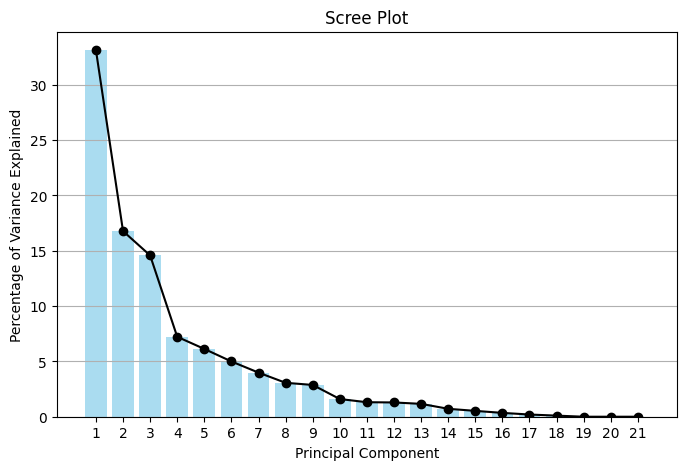

In [35]:
# Run PCA
pca = PCA()
pca.fit(X_scaled)

# Variance explained per PC (in %)
explained_variance_percent = pca.explained_variance_ratio_ * 100

# Plotting a Scree plot
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance_percent)+1), explained_variance_percent, alpha=0.7, color='skyblue')
plt.plot(range(1, len(explained_variance_percent)+1), explained_variance_percent, marker='o', color='black')  
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Scree Plot')
plt.xticks(range(1, len(explained_variance_percent)+1))  
plt.grid(axis='y')
plt.show()


In [37]:
# Determine k (number of PCs explaining >= 80% of variance)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
k = np.argmax(cumulative_variance >= 0.80) + 1
print("Number of PCs explaining ≥80% variance:", k)


Number of PCs explaining ≥80% variance: 6


### PCA with an expanding window 

In [38]:
min_window = 30  
pc_scores_list = []

for i in range(min_window-1, len(X_numeric)):
    # Expanding window: all data from start to current day
    window_data = X_numeric.iloc[:i+1]
    
    # Standardize data 
    scaler_window = StandardScaler()
    X_scaled = scaler_window.fit_transform(window_data)
    
    # PCA with fixed 6 PCs
    pca_window = PCA(n_components=k)
    pca_window.fit(X_scaled)
    
    # Get PC scores for the last day only
    last_day_score = pca_window.transform(X_scaled)[-1]
    pc_scores_list.append(last_day_score)

# Convert to DataFrame
timestamps_pre_event = data_before_event['timestamp']
pc_scores_df = pd.DataFrame(pc_scores_list, columns=[f'PC{i+1}' for i in range(k)])
pc_scores_df['timestamp'] = timestamps_pre_event.iloc[min_window-1:].values



### Plots


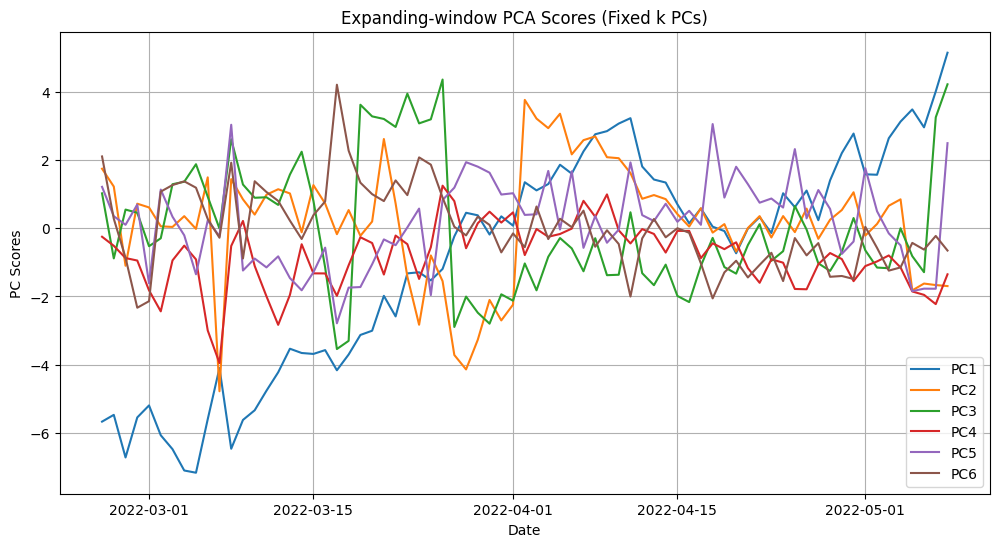

In [39]:
# Line Plot
# Plot PC scores over time
plt.figure(figsize=(12,6))
for i in range(k):
    plt.plot(pc_scores_df['timestamp'], pc_scores_df[f'PC{i+1}'], label=f'PC{i+1}')
plt.xlabel('Date')
plt.ylabel('PC Scores')
plt.title('Expanding-window PCA Scores (Fixed k PCs)')
plt.legend()
plt.grid(True)
plt.show()

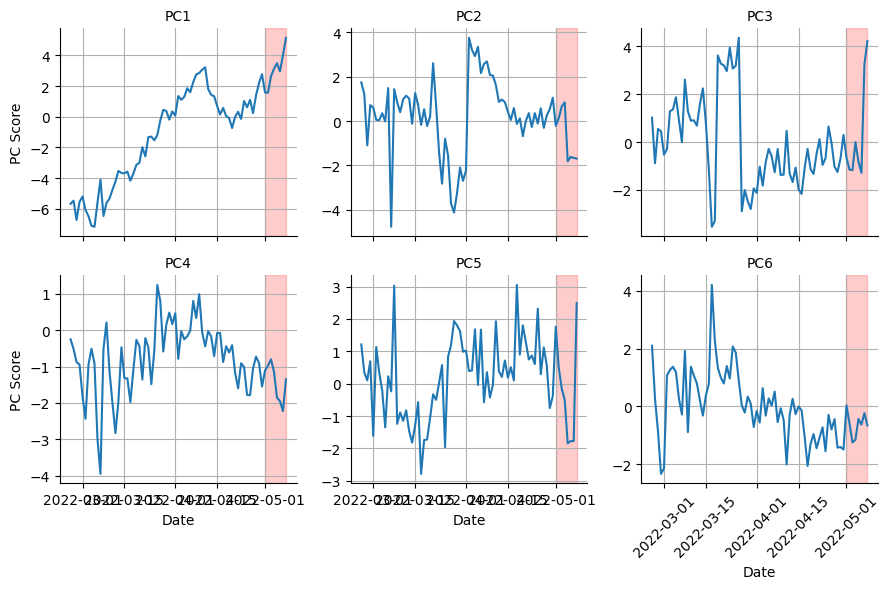

In [40]:

# Facet Grid Plot
# Melt the DataFrame so we have: timestamp | PC | score
pc_long = pc_scores_df.melt(id_vars='timestamp', var_name='PC', value_name='score')

# Convert timestamp to datetime 
pc_long['timestamp'] = pd.to_datetime(pc_long['timestamp'])

# Create FacetGrid 
g = sns.FacetGrid(pc_long, col='PC', col_wrap=3, height=3, sharex=True, sharey=False)

# Map the lineplot
g.map_dataframe(sns.lineplot, x='timestamp', y='score', color='tab:blue')

# Add shaded region for pre-event window
for ax in g.axes.flatten():
    ax.axvspan(pre_event_start, pre_event_end, color='red', alpha=0.2) 
    ax.grid(True)

# Labels and titles
g.set_axis_labels('Date', 'PC Score')
g.set_titles(col_template='{col_name}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



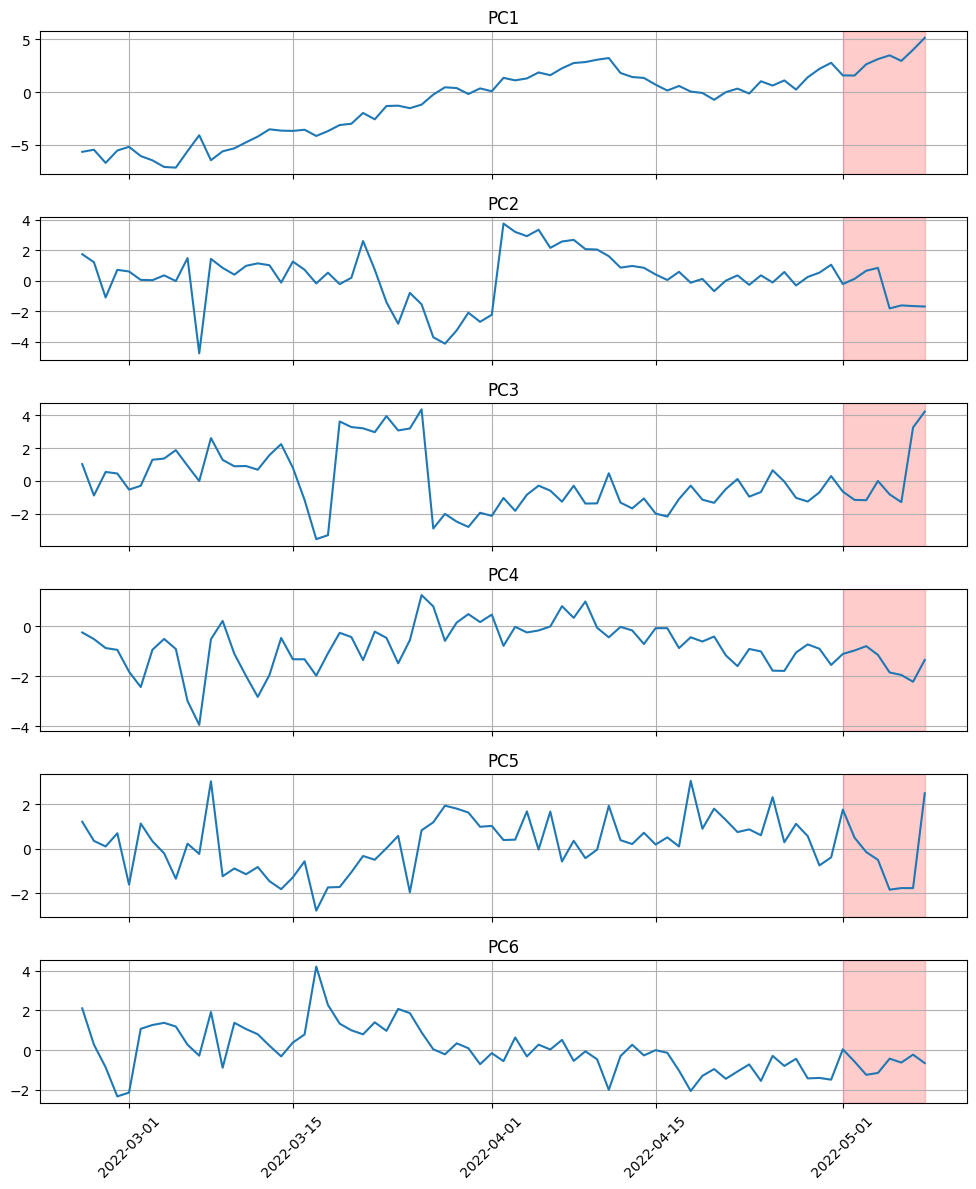

In [41]:
# Stacked Sub-plots
pcs = pc_scores_df.columns.drop('timestamp')

fig, axes = plt.subplots(len(pcs), 1, figsize=(10, 12), sharex=True)

for i, pc in enumerate(pcs):
    axes[i].plot(pc_scores_df['timestamp'], pc_scores_df[pc])
    axes[i].set_title(pc)
    axes[i].axvspan(pre_event_start, pre_event_end, color = 'red', alpha=0.2)
    axes[i].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


PC1: exhibits a clear upward drift entering the pre-event window, suggesting increasing systemic pressure prior to the TerraUSD collapse.  
PC2:       
PC3: shows a large spike immediately prior to the collapse, indicating potential instability emerging in secondary factors.  
PC4:  
PC5:  
PC6: relatively stable, limited relevance for early warning.  

### Biplots

In [42]:
# Biplot function
def biplot(scores, loadings, feature_names, explained_variance, pc_x=1, pc_y=2, 
           scale_scores=1, scale_loadings=1):
    
    x_idx = pc_x - 1
    y_idx = pc_y - 1
    
    plt.figure(figsize=(10,8))
    
    # Plot scores
    plt.scatter(scores[:, x_idx] * scale_scores, scores[:, y_idx] * scale_scores,
                alpha=0.5, color='steelblue', label='Observations')
    
    # Plot loadings 
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0,
                  loadings[i, x_idx] * scale_loadings,
                  loadings[i, y_idx] * scale_loadings,
                  color='red', alpha=0.7, head_width=0.05)
        plt.text(loadings[i, x_idx] * scale_loadings * 1.15,
                 loadings[i, y_idx] * scale_loadings * 1.15,
                 feature, color='black', ha='center', va='center', fontsize=9)
    
    plt.xlabel(f'PC{pc_x} ({explained_variance[x_idx]:.1f}% variance)')
    plt.ylabel(f'PC{pc_y} ({explained_variance[y_idx]:.1f}% variance)')
    plt.title(f'PCA Biplot: PC{pc_x} vs PC{pc_y}')
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.show()



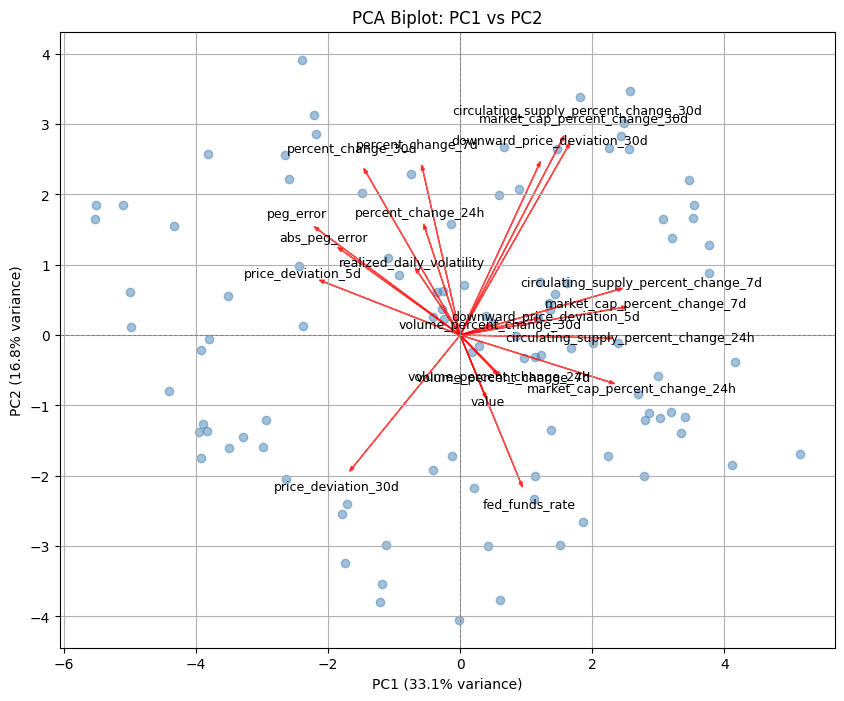

In [29]:
# PC1 vs PC2
numeric_cols_list = numeric_cols.tolist()
biplot(scores=pca.transform(X_scaled), 
       loadings=pca.components_.T, 
       feature_names=numeric_cols_list, 
       explained_variance=explained_variance_percent, 
       pc_x=1, pc_y=2, 
       scale_scores=1, scale_loadings=7)
